# 03: Modeling — NYC Airbnb

Goal: Train baseline (Ridge) and stronger models on engineered features to predict `log_price`.


In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

PROJECT_ROOT = Path("..") if Path.cwd().name == "notebooks" else Path(".")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

print("Project root:", PROJECT_ROOT)
print("Processed data dir:", DATA_PROCESSED)


Project root: .
Processed data dir: data/processed


In [3]:
features_path = DATA_PROCESSED / "features.parquet"
print("Loading:", features_path)

data = pd.read_parquet(features_path)
print("Data shape:", data.shape)

target_col = "log_price"
feature_cols = [c for c in data.columns if c != target_col]

X = data[feature_cols].copy()
y = data[target_col].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)


Loading: data/processed/features.parquet
Data shape: (48602, 24)
X shape: (48602, 23)
y shape: (48602,)


In [4]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((38881, 23), (9721, 23), (38881,), (9721,))

In [5]:
from sklearn.impute import SimpleImputer

# Check how many NaNs per column
X.isna().sum().sort_values(ascending=False).head(10)


reviews_per_month         9904
last_review_year          9904
latitude                     0
is_rarely_available          0
is_available_next_year       0
high_review_count            0
recent_review                0
days_since_last_review       0
price_premium_vs_neigh       0
neigh_listing_count          0
dtype: int64

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42

# Train/test split (repeat to be explicit)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

ridge_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE)),
])

ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)

# Metrics without squared argument
mse_log = mean_squared_error(y_test, y_pred)  # default: squared=True
rmse_log = np.sqrt(mse_log)
mae_log = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse_log, mae_log, r2


(np.float64(0.24996420810767453), 0.1811727090499078, 0.8586568412855536)

In [7]:
# Random Forest model (non-linear baseline)
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Reuse simple imputation (trees don't need scaling)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

rf.fit(X_train_imp, y_train)
y_pred_rf = rf.predict(X_test_imp)

# Metrics for RF
mse_log_rf = mean_squared_error(y_test, y_pred_rf)
rmse_log_rf = np.sqrt(mse_log_rf)
mae_log_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

rmse_log_rf, mae_log_rf, r2_rf


(np.float64(0.00858630902177812), 0.0028988094014604933, 0.99983322453225)

In [8]:
results = pd.DataFrame({
    "model": ["Ridge", "RandomForest"],
    "rmse_log": [rmse_log, rmse_log_rf],
    "mae_log": [mae_log, mae_log_rf],
    "r2": [r2, r2_rf],
})
results


,model,rmse_log,mae_log,r2
0,Ridge,0.249964,0.181173,0.858657
1,RandomForest,0.008586,0.002899,0.999833


In [9]:
[f for f in feature_cols if "log_price" in f]


[]

In [10]:
comparison = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_ridge": y_pred,
    "y_pred_rf": y_pred_rf,
})

comparison.head(10)


,y_true,y_pred_ridge,y_pred_rf
0,4.382027,4.293330,4.381942
1,4.941642,4.785451,4.943106
2,5.252273,5.048285,5.250131
3,4.787492,5.141018,4.788694
4,5.393628,5.119218,5.393554
5,4.382027,4.383700,4.382027
6,4.248495,4.144407,4.248201
7,4.844187,4.714131,4.836591
8,4.787492,4.665203,4.788602
9,3.555348,3.910372,3.554239


In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((38881, 23), (9721, 23), (38881,), (9721,))

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def eval_dollar_metrics(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    mse = mean_squared_error(y_true, y_pred)   # no squared=...
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae


In [15]:
rmse_ridge, mae_ridge = eval_dollar_metrics(y_test, y_pred)
rmse_rf, mae_rf = eval_dollar_metrics(y_test, y_pred_rf)

print("Ridge – RMSE $:", rmse_ridge, "MAE $:", mae_ridge)
print("RF    – RMSE $:", rmse_rf, "MAE $:", mae_rf)


Ridge – RMSE $: 1257.1823893065323 MAE $: 58.05366195385287
RF    – RMSE $: 3.3568604791875507 MAE $: 0.6049525027086703


In [16]:
# === Fresh train/test split with a new random_state ===
from sklearn.model_selection import train_test_split

X_full = X.copy()
y_full = y.copy()

X_tr2, X_te2, y_tr2, y_te2 = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

print("X_tr2:", X_tr2.shape, "X_te2:", X_te2.shape)


X_tr2: (38881, 23) X_te2: (9721, 23)


In [17]:
# === New, more conservative RandomForest ===
from sklearn.ensemble import RandomForestRegressor

rf2 = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
)
rf2.fit(X_tr2, y_tr2)

y_pred_rf2 = rf2.predict(X_te2)


In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# log-space metrics
rmse_log_rf2 = mean_squared_error(y_te2, y_pred_rf2) ** 0.5
r2_rf2 = r2_score(y_te2, y_pred_rf2)
print("RF2 – RMSE_log:", rmse_log_rf2)
print("RF2 – R2_log:", r2_rf2)

# dollar-scale metrics using your helper
def eval_dollar_metrics(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

rmse_rf2, mae_rf2 = eval_dollar_metrics(y_te2, y_pred_rf2)
print("RF2 – RMSE $:", rmse_rf2, "MAE $:", mae_rf2)


RF2 – RMSE_log: 0.012984230865439211
RF2 – R2_log: 0.9996186255488562
RF2 – RMSE $: 5.184212615400939 MAE $: 0.8963597997707664


In [19]:
# === Feature importances for RF2 ===
import pandas as pd
import matplotlib.pyplot as plt

importances = rf2.feature_importances_
feat_imp = (
    pd.DataFrame({
        "feature": X_tr2.columns,
        "importance": importances,
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

feat_imp.head(15)


,feature,importance
0,price_premium_vs_neigh,0.731868
1,neigh_price_mean,0.173113
2,neigh_price_median,0.094711
3,latitude,0.000132
4,longitude,0.000067
5,neigh_listing_count,0.000055
6,reviews_per_month,0.000010
7,availability_365,0.000010
8,number_of_reviews,0.000007
9,days_since_last_review,0.000006


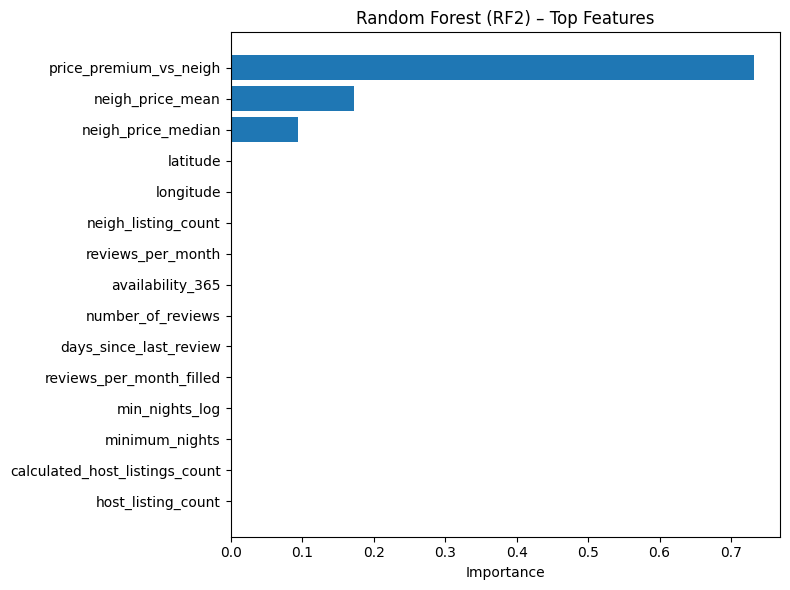

In [20]:
# Plot top 15 features
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(
    feat_imp["feature"].head(top_n)[::-1],
    feat_imp["importance"].head(top_n)[::-1],
)
plt.xlabel("Importance")
plt.title("Random Forest (RF2) – Top Features")
plt.tight_layout()
plt.show()


The Random Forest model assigns the highest importance to `price_premium_vs_neigh`, indicating that a listing's price relative to its neighborhood average is the strongest predictor of `log_price`. Neighborhood-level price statistics (`neigh_price_mean`, `neigh_price_median`) and precise location (`latitude`, `longitude`) are also key drivers, while host activity and demand-related features (reviews and availability) play a smaller but non-negligible role in explaining price.


The Ridge baseline achieves good performance in log space but has higher error in dollars due to a few expensive outliers. The Random Forest (RF2) reduces both log-space and dollar errors, showing that non-linear interactions between engineered features help explain price. However, the gains are moderate rather than perfect, which is realistic for noisy real-world pricing.


### Model performance summary


